In [1]:
import cv2
import numpy as np
import PIL
import io
import html
import time
import imageio
import matplotlib.pyplot as plt
import BodyTracker as Bt
from utils import *
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import dtw_ndim
import random


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject


## V2

In [2]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def detectPose(img):

    if img is None:
        return None
        
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        # Recolor image to RGB
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

        return image



In [4]:

def detectLeftHandPose(img):

    if img is None:
        return None
        
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        # Recolor image to RGB
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #print(results.pose_landmarks.landmark)

        # Create an empty NormalizedLandmarkList object
        landmark_list = mp.framework.formats.landmark_pb2.NormalizedLandmarkList()

        # Create 22 NormalizedLandmark objects
        for _ in range(33):
            landmark = landmark_list.landmark.add()
            landmark.Clear()
            landmark.x = 0
            landmark.y = 0
            landmark.z = 0
            landmark.visibility = 0

        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].z
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].visibility

        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].x
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].y
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].z
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].visibility

        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].x
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].y
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].z
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].visibility

        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].x
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].y
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].z
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].visibility
        # Render detections
        mp_drawing.draw_landmarks(image, landmark_list, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

        return image

In [5]:
def trackJoints(img):

    if img is None:
        return None
        
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        # Recolor image to RGB
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
        lmList = []
        try:
            landmarks = results.pose_landmarks.landmark
            for id, lm in enumerate(results.pose_landmarks.landmark):
                h, w, c = img.shape
                # print(id, lm)
                cx, cy = int(lm.x * w), int(lm.y * h)
                #cx, cy = lm.x, lm.y
                lmList.append([id, cx, cy])
            #print(landmarks)
        except:
            pass
        
        return lmList

In [6]:

def trackLeftHandJoints(joints):
    
    lmList = []
    lmList.append(joints[mp_pose.PoseLandmark.LEFT_WRIST])
    lmList.append(joints[mp_pose.PoseLandmark.LEFT_PINKY])
    lmList.append(joints[mp_pose.PoseLandmark.LEFT_INDEX])
    lmList.append(joints[mp_pose.PoseLandmark.LEFT_THUMB])
    return lmList

In [7]:
# a:first point b:middle point c:last point
def detectAngles(a, b, c):

    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [475]:
v1 = "videos/VID_20221222_184119.mp4"
v2 = "videos/VID_20221222_184132.mp4"
v3 = "videos/new1.mp4"

In [79]:
nbrFrames1 = 116

In [473]:
cap1=cv2.VideoCapture(v1)
cap2=cv2.VideoCapture(v2)
size = (400,600)
cpt = 0
frameRate = cap1.get(cv2.CAP_PROP_FPS)
out1 = cv2.VideoWriter('videos/new1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), frameRate, size) # Output video

while True:

    
    success, img1 = cap1.read()
    success1, img2 = cap2.read()
    

    if success is False or img1 is None:
        break

    if success1 is False or img2 is None:
        break


    img1 = cv2.resize(img1, size) 
    img2 = cv2.resize(img2, size) 

    if cpt < 90:
        out1.write(img1)
    else:
        out1.write(img2)
    
    cv2.imshow('Mediapipe Feed1', img1)
    cv2.imshow('Mediapipe Feed2', img2)

    cpt = cpt + 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap1.release()
cap2.release()
out1.release()

cv2.destroyAllWindows()


In [78]:
print(nbrFrames2)
print(nbrFrames1)

152
116


In [474]:
cap=cv2.VideoCapture(v1)
keypoints1 = []
leftHandKeypoints1 = []
while cap.isOpened():
    ret, frame = cap.read()

    if frame is None:
        break
    landmarks = trackJoints(frame)
    handLandmarks = trackLeftHandJoints(landmarks)
    keypoints1.append(landmarks)
    leftHandKeypoints1.append(handLandmarks)

cap.release()
cv2.destroyAllWindows()  

In [476]:
cap=cv2.VideoCapture(v3)
keypoints2 = []
leftHandKeypoints2 = []
while cap.isOpened():
    ret, frame = cap.read()

    if frame is None:
        break
    landmarks = trackJoints(frame)
    handLandmarks = trackLeftHandJoints(landmarks)
    keypoints2.append(landmarks)
    leftHandKeypoints2.append(handLandmarks)

cap.release()
cv2.destroyAllWindows()  

In [424]:
leftHandKeypoints2[0]

[[15, 126, 147], [17, 127, 152], [19, 128, 153], [21, 127, 151]]

In [537]:
cap=cv2.VideoCapture(v2)
size = (400,600)
out1 = cv2.VideoWriter('allKp2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, size) # Output video
nbrFrames1 = 0

while cap.isOpened():

    ret, frame = cap.read()

    if frame is None:
        break

    image = detectLeftHandPose(frame)

    image = cv2.resize(image, (400, 600))

    out1.write(image)
    
    cv2.imshow('Mediapipe Feed', image)
    nbrFrames1 = nbrFrames1 + 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out1.release()
cv2.destroyAllWindows()


In [477]:
allKp1Hand = []
allKp2Hand = []

for i in range(0, len(leftHandKeypoints1)):
    allKp1Hand.append(np.array(leftHandKeypoints1[i]))

for i in range(0, len(leftHandKeypoints2)):
    allKp2Hand.append(np.array(leftHandKeypoints2[i]))


In [478]:
allKp1Wrist = []
allKp2Wrist = []

for i in range(0, len(leftHandKeypoints1)):
    allKp1Wrist.append(np.array(leftHandKeypoints1[i][0]))

for i in range(0, len(leftHandKeypoints2)):
    allKp2Wrist.append(np.array(leftHandKeypoints2[i][0]))


In [479]:
allKp1Wrist

[array([ 15, 507, 679]),
 array([ 15, 506, 683]),
 array([ 15, 504, 675]),
 array([ 15, 508, 680]),
 array([ 15, 508, 681]),
 array([ 15, 512, 682]),
 array([ 15, 526, 683]),
 array([ 15, 541, 683]),
 array([ 15, 559, 681]),
 array([ 15, 583, 665]),
 array([ 15, 614, 658]),
 array([ 15, 644, 627]),
 array([ 15, 676, 596]),
 array([ 15, 689, 544]),
 array([ 15, 710, 517]),
 array([ 15, 721, 471]),
 array([ 15, 733, 423]),
 array([ 15, 743, 390]),
 array([ 15, 700, 310]),
 array([ 15, 713, 277]),
 array([ 15, 688, 223]),
 array([ 15, 680, 179]),
 array([ 15, 685, 127]),
 array([ 15, 668,  99]),
 array([ 15, 632,  84]),
 array([ 15, 588,  74]),
 array([ 15, 539,  35]),
 array([ 15, 501,  27]),
 array([ 15, 476,  30]),
 array([ 15, 448,  39]),
 array([ 15, 421,  27]),
 array([ 15, 396,  27]),
 array([ 15, 373,  17]),
 array([ 15, 331,  20]),
 array([ 15, 327,  19]),
 array([ 15, 336,  12]),
 array([ 15, 359,  10]),
 array([ 15, 368,  16]),
 array([ 15, 375,   9]),
 array([ 15, 408,  34]),


In [480]:
print(len(allKp1Hand))
print(len(allKp2Hand))

116
116


In [481]:
print(len(allKp1Wrist))
print(len(allKp2Wrist))

116
116


In [482]:
dtwKp1Wrist = []
dtwKp2Wrist = []

for i in range(0, len(allKp1Wrist)):
    dtwKp1Wrist.append([np.double(allKp1Wrist[i][1]) , np.double(allKp1Wrist[i][2])])

for i in range(0, len(allKp2Wrist)):
   dtwKp2Wrist.append([np.double(allKp2Wrist[i][1]) , np.double(allKp2Wrist[i][2])])

dtwKp1Wrist = np.array(dtwKp1Wrist)
dtwKp2Wrist = np.array(dtwKp2Wrist) 

In [483]:
dtwKp1Wrist

array([[507., 679.],
       [506., 683.],
       [504., 675.],
       [508., 680.],
       [508., 681.],
       [512., 682.],
       [526., 683.],
       [541., 683.],
       [559., 681.],
       [583., 665.],
       [614., 658.],
       [644., 627.],
       [676., 596.],
       [689., 544.],
       [710., 517.],
       [721., 471.],
       [733., 423.],
       [743., 390.],
       [700., 310.],
       [713., 277.],
       [688., 223.],
       [680., 179.],
       [685., 127.],
       [668.,  99.],
       [632.,  84.],
       [588.,  74.],
       [539.,  35.],
       [501.,  27.],
       [476.,  30.],
       [448.,  39.],
       [421.,  27.],
       [396.,  27.],
       [373.,  17.],
       [331.,  20.],
       [327.,  19.],
       [336.,  12.],
       [359.,  10.],
       [368.,  16.],
       [375.,   9.],
       [408.,  34.],
       [432.,  54.],
       [436.,  30.],
       [456.,  22.],
       [477.,  19.],
       [498.,  43.],
       [524.,  31.],
       [557.,  58.],
       [582.,

In [484]:
print(dtwKp2Wrist.shape)
#print(nbrFrames1)

(116, 2)


In [485]:
model_points = dtwKp1Wrist/ np.linalg.norm(dtwKp1Wrist)
input_points = dtwKp2Wrist/np.linalg.norm(dtwKp2Wrist)

In [486]:
d = dtw_ndim.distance(model_points, input_points)
print(d)

0.13158487563163634


In [487]:
s = int(100 - (d* 100))
print(s)

86


In [520]:

distance, paths = dtw_ndim.warping_paths(dtwKp1Wrist, dtwKp2Wrist)

In [546]:
distance, paths = dtw_ndim.warping_paths(dtwKp1Wrist, dtwKp2Wrist, window = 4)

In [547]:
len(paths[0])

117

In [548]:
distance

4293.609553743796

In [523]:
paths

array([[   0.        ,           inf,           inf, ...,           inf,
                  inf,           inf],
       [          inf,  426.75519915,  603.89817022, ..., 5836.12782588,
        5858.48384823, 5880.51103221],
       [          inf,  605.55841997,  605.93068911, ..., 5836.34757361,
        5858.70224538, 5880.72759104],
       ...,
       [          inf, 4463.15180114, 4463.20344596, ..., 4194.06938426,
        4205.49640352, 4216.97332218],
       [          inf, 4484.39583445, 4484.44701162, ..., 4215.22419333,
        4226.20905777, 4237.20532899],
       [          inf, 4505.42639492, 4505.47755515, ..., 4236.45264343,
        4247.08900307, 4257.64970377]])

In [524]:

#distance, paths = dtw_ndim.warping_paths_fast(dtwKp1Wrist, dtwKp2Wrist)

In [549]:
best_path_Wrist = dtw.best_path(paths)
len(best_path_Wrist)

122

(<Figure size 1000x1000 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

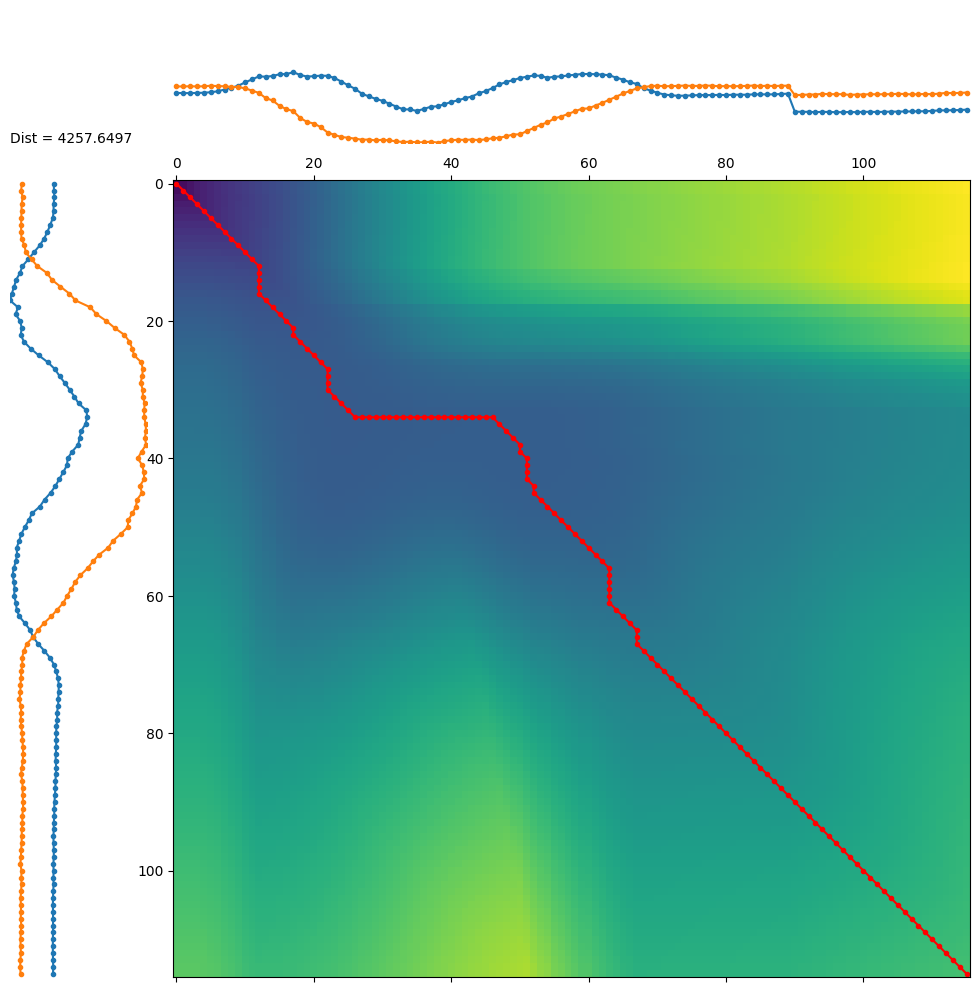

In [526]:
dtwvis.plot_warpingpaths(dtwKp1Wrist, dtwKp2Wrist, paths, best_path_Wrist)

(<Figure size 1000x1000 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

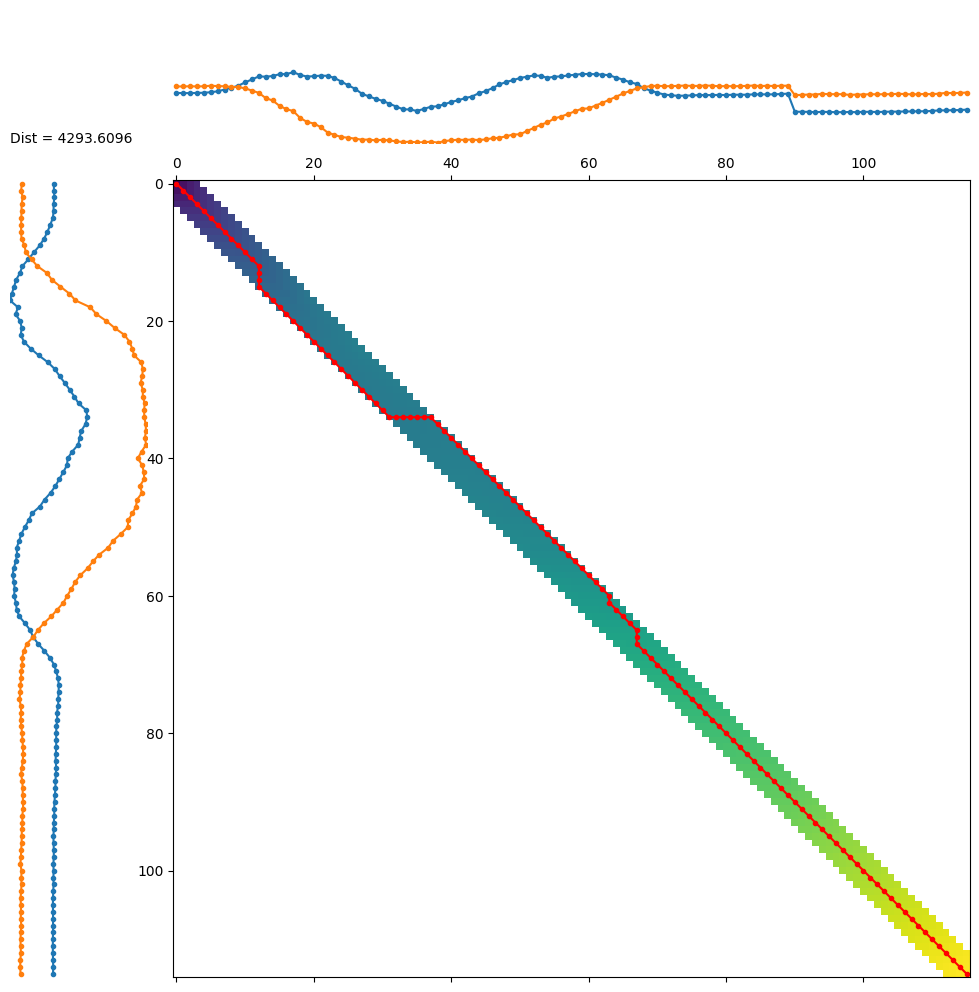

In [550]:
dtwvis.plot_warpingpaths(dtwKp1Wrist, dtwKp2Wrist, paths, best_path_Wrist)

In [519]:
best_path_Wrist

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 12),
 (14, 12),
 (15, 12),
 (16, 12),
 (17, 13),
 (18, 14),
 (19, 15),
 (20, 16),
 (21, 17),
 (22, 17),
 (23, 18),
 (24, 19),
 (25, 20),
 (26, 21),
 (27, 22),
 (28, 22),
 (29, 22),
 (30, 22),
 (31, 23),
 (32, 24),
 (33, 25),
 (34, 26),
 (34, 27),
 (34, 28),
 (34, 29),
 (34, 30),
 (34, 31),
 (34, 32),
 (34, 33),
 (34, 34),
 (34, 35),
 (34, 36),
 (34, 37),
 (34, 38),
 (34, 39),
 (34, 40),
 (34, 41),
 (34, 42),
 (34, 43),
 (34, 44),
 (34, 45),
 (34, 46),
 (35, 47),
 (36, 48),
 (37, 49),
 (38, 50),
 (39, 50),
 (40, 51),
 (41, 51),
 (42, 51),
 (43, 51),
 (44, 52),
 (45, 52),
 (46, 53),
 (47, 54),
 (48, 55),
 (49, 56),
 (50, 57),
 (51, 58),
 (52, 59),
 (53, 60),
 (54, 61),
 (55, 62),
 (56, 63),
 (57, 63),
 (58, 63),
 (59, 63),
 (60, 63),
 (61, 63),
 (62, 64),
 (63, 65),
 (64, 66),
 (65, 67),
 (66, 67),
 (67, 67),
 (68, 68),
 (69, 69),
 (70, 70),
 (71, 71),
 (72, 72

In [527]:
best_path_Wrist

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 12),
 (14, 12),
 (15, 12),
 (16, 12),
 (17, 13),
 (18, 14),
 (19, 15),
 (20, 16),
 (21, 17),
 (22, 17),
 (23, 18),
 (24, 19),
 (25, 20),
 (26, 21),
 (27, 22),
 (28, 22),
 (29, 22),
 (30, 22),
 (31, 23),
 (32, 24),
 (33, 25),
 (34, 26),
 (34, 27),
 (34, 28),
 (34, 29),
 (34, 30),
 (34, 31),
 (34, 32),
 (34, 33),
 (34, 34),
 (34, 35),
 (34, 36),
 (34, 37),
 (34, 38),
 (34, 39),
 (34, 40),
 (34, 41),
 (34, 42),
 (34, 43),
 (34, 44),
 (34, 45),
 (34, 46),
 (35, 47),
 (36, 48),
 (37, 49),
 (38, 50),
 (39, 50),
 (40, 51),
 (41, 51),
 (42, 51),
 (43, 51),
 (44, 52),
 (45, 52),
 (46, 53),
 (47, 54),
 (48, 55),
 (49, 56),
 (50, 57),
 (51, 58),
 (52, 59),
 (53, 60),
 (54, 61),
 (55, 62),
 (56, 63),
 (57, 63),
 (58, 63),
 (59, 63),
 (60, 63),
 (61, 63),
 (62, 64),
 (63, 65),
 (64, 66),
 (65, 67),
 (66, 67),
 (67, 67),
 (68, 68),
 (69, 69),
 (70, 70),
 (71, 71),
 (72, 72

In [253]:

def SimiLarLeftHandPose(img, bPath, cpt):

    if img is None:
        return None
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        # Recolor image to RGB
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #print(results.pose_landmarks.landmark)

        # Create an empty NormalizedLandmarkList object
        landmark_list = mp.framework.formats.landmark_pb2.NormalizedLandmarkList()

        # Create 22 NormalizedLandmark objects
        for _ in range(33):
            landmark = landmark_list.landmark.add()
            landmark.Clear()
            landmark.x = 0
            landmark.y = 0
            landmark.z = 0
            landmark.visibility = 0
        
        if cpt + 4 > len(bPath):
            return img

        for i in range(cpt, cpt + 4):
            if (bPath[i][1] == bPath[i][0]):
                if cpt%4 == 0:
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].z
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].visibility
                if cpt%4 == 1:
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].x
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].y
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].z
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_PINKY].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_PINKY].visibility
                if cpt%4 == 2:
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].x
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].y
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].z
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_INDEX].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].visibility
                if cpt%4 == 3:
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].x
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].y
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].z
                    landmark_list.landmark[mp_pose.PoseLandmark.LEFT_THUMB].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_THUMB].visibility
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, landmark_list, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )
        
        return image



In [544]:

def SimiLarLeftWristPose(img, bPath, cpt):

    if img is None:
        return None
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        # Recolor image to RGB
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #print(results.pose_landmarks.landmark)

        # Create an empty NormalizedLandmarkList object
        landmark_list = mp.framework.formats.landmark_pb2.NormalizedLandmarkList()

        # Create 22 NormalizedLandmark objects
        for _ in range(33):
            landmark = landmark_list.landmark.add()
            landmark.Clear()
            landmark.x = 0
            landmark.y = 0
            landmark.z = 0
            landmark.visibility = 0

        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].z
        landmark_list.landmark[mp_pose.PoseLandmark.LEFT_WRIST].visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].visibility

        if bPath[cpt][1] == bPath[cpt][0]:
                    # Render detections
            mp_drawing.draw_landmarks(image, landmark_list, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(230,123,255), thickness=4, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(230,123,255), thickness=4, circle_radius=2)
            )
        else:
            mp_drawing.draw_landmarks(image, landmark_list, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(0,0,255), thickness=4, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(0,0,255), thickness=4, circle_radius=2)
            )
            

        return image



In [545]:
cap1=cv2.VideoCapture(v1)
cap2=cv2.VideoCapture(v2)
size = (400,600)

out1 = cv2.VideoWriter('similarKp1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video
out2 = cv2.VideoWriter('similarKp2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video

cpt = 0

while True:

    
    success, img1 = cap1.read()
    success1, img2 = cap2.read()
    

    if success is False or img1 is None:
        break

    if success1 is False or img2 is None:
        break

            
    img1 = SimiLarLeftWristPose(img1, best_path_Wrist, cpt)
    img2 = SimiLarLeftWristPose(img2, best_path_Wrist, cpt)

    img1 = cv2.resize(img1, size) 
    img2 = cv2.resize(img2, size) 

    out1.write(img1)
    out2.write(img2)

    #cpt = cpt + 4
    cpt = cpt + 1
    cv2.imshow('Mediapipe Feed1', img1)
    cv2.imshow('Mediapipe Feed2', img2)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap1.release()
cap2.release()
out1.release()
out2.release()
cv2.destroyAllWindows()


## FIXED IMAGE

## V3

In [420]:
cap1=cv2.VideoCapture(v1)
cap2=cv2.VideoCapture(v3)
size = (400,600)

out1 = cv2.VideoWriter('similarKp1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video
out2 = cv2.VideoWriter('similarKp2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video

cpt = 0

total_score = 0
distances = []
scores = []
while True:

    
    success, img1 = cap1.read()
    success1, img2 = cap2.read()
    

    if success is False or img1 is None:
        break

    if success1 is False or img2 is None:
        break

    landmarks1 = trackJoints(img1)
    handLandmarks1 = trackLeftHandJoints(landmarks1)
    landmarks2 = trackJoints(img2)
    handLandmarks2 = trackLeftHandJoints(landmarks2)
    
    allKp1Hand = []
    allKp2Hand = []

    for i in range(0, len(handLandmarks1)):
        allKp1Hand.append(np.array(handLandmarks1[i]))
    for i in range(0, len(handLandmarks2)):
        allKp2Hand.append(np.array(handLandmarks2[i]))

    dtwKp1Hand = []
    dtwKp2Hand = []

    for i in range(0, len(allKp1Hand)):
        dtwKp1Hand.append([allKp1Hand[i][1], allKp1Hand[i][2]])
    for i in range(0, len(allKp2Hand)):
        dtwKp2Hand.append([allKp2Hand[i][1], allKp2Hand[i][2]])
   

    dtwKp1Hand = np.array(dtwKp1Hand)
    dtwKp2Hand = np.array(dtwKp2Hand)

    dtwKp1Hand = dtwKp1Hand / np.linalg.norm(dtwKp1Hand)
    dtwKp2Hand = dtwKp2Hand / np.linalg.norm(dtwKp2Hand)
    
    d = dtw_ndim.distance(dtwKp1Hand, dtwKp2Hand) 
    s = 100 - (d * 100)
    distances.append(d)
    scores.append(s)
    

    img1 = cv2.resize(img1, size) 
    img2 = cv2.resize(img2, size) 

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    text_size, _ = cv2.getTextSize(str(s), font, font_scale, font_thickness)
    text_x = int((img1.shape[1] - text_size[0]) / 2)  # center the text horizontally
    text_y = 50  # set the vertical position of the text
    cv2.putText(img1, str(s), (text_x, text_y), font, font_scale, (0, 0, 255), font_thickness)

    
    cv2.imshow('Mediapipe Feed1', img1)
    cv2.imshow('Mediapipe Feed2', img2)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap1.release()
cap2.release()
out1.release()
out2.release()
cv2.destroyAllWindows()


In [89]:
len(scores)

116

In [87]:
total_score = np.mean(scores)
print(total_score)

50.0242852978308


## V1

In [25]:
def pose(img):
    
    pTime = 0    
    lmList=[]

    nframes=30 # is the number of saved frames for the function live_tracker
    iterator=0
    angles=[]
    refTime=time.time()
    tracker=live_tracker(nframes)

     #positioning of text and dimensions
    h_angle=50
    w_angle=100
    h_j=65
    w_j=w_angle
    fontScale=2
    thickness=2

    width,height, c=img.shape
    size=(width, height)
    #writer= cv2.VideoWriter('runpose.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (width,height))
    img = detector.findPose(img)
    lmList = detector.findPosition(img)
    #print(img)
    points=[12, 14, 16]
    p=points
    maxim=max(points)
    angle=0
    lmList1=[]
    inf=60
    sup=140
    #draw angle and perform evaluation
    """if(maxim>len(lmList)):
        draw=False
    if(search(lmList, p[0])  and search(lmList, p[1] ) ) and ( search(lmList, p[2]) ):
        draw=True"""
    angle=detector.findAngle(img, p[0], p[1], p[2]), 
    angles.append(angle)
    if(True):
        judge(img, angle, inf, sup)
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    lmList1.append(lmList)
    img = cv2.resize(img, (400, 500))
    
    #ori1.write(img)
    #ori2.write(img)
    cv2.imshow("Capture1",img)
    #writer.write(img)
    return cTime,lmList1


In [26]:
#v1='videos/push2.avi'
#v2='videos/push1.avi'
#v1='videos/pick1.avi'
#v2='videos/pick2.avi'
v1 = "videos/VID_20221222_184119.mp4"
v2 = "videos/VID_20221222_184132.mp4"

In [27]:
detector = Bt.poseDetector()
cap1=cv2.VideoCapture(v1)

allDistances = []
nframes=30 # is the number of saved frames for the function live_tracker
refTime=time.time()
w_angle=100

kp1_list = []

try:
    duration=args.max_len
    if duration is None:
        duration=25
except:
    duration=40


#ori1 = cv2.VideoWriter('original1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, size)

while True:
    success, img1 = cap1.read()
    
    if success is False or img1 is None:
        break

    cTime1, Kp1=pose(img1)
    #print(Kp1[0])
    Kp1= np.array(Kp1)
    Kp1 = Kp1.flatten()
    kp1_list.append(Kp1)
    
    if (cTime1-refTime)>duration:
        break

    key=cv2.waitKey(10)
    if key == ord('q'):
        break

    if (cTime1-refTime)>duration:
        print("end ")
        break

cv2.destroyAllWindows()
#ori1.release()
cap1.release()
 


In [28]:
detector = Bt.poseDetector()

cap2=cv2.VideoCapture(v2)

size = (400, 500)
allDistances = []
nframes=30 # is the number of saved frames for the function live_tracker
refTime=time.time()
w_angle=100

kp2_list = []

try:
    duration=args.max_len
    if duration is None:
        duration=25
except:
    duration=40


#ori2 = cv2.VideoWriter('original2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, size)

while True:
    
    success1, img2 = cap2.read() 

    if success1 is False or img2 is None:
        break

    cTime2, Kp2=pose(img2)
    Kp2= np.array(Kp2)
    Kp2 = Kp2.flatten()
    kp2_list.append(Kp2)
    
    
    if (cTime2-refTime)>duration:
        break

    key=cv2.waitKey(10)
    if key == ord('q'):
        break

    if (cTime2-refTime)>duration:
        print("end ")
        break

cv2.destroyAllWindows()
#ori2.release()
cap2.release() 


#### Check empty elements in Kp1 - Kp2

In [6]:
empty_array_indices_kp1 = []
empty_array_indices_kp2 = []
for i, arr in enumerate(kp1_list):
    if arr.size == 0:
        empty_array_indices_kp1.append(i)

for i, arr in enumerate(kp2_list):
    if arr.size == 0:
        empty_array_indices_kp2.append(i)

print("kp1", empty_array_indices_kp1)
print("kp2", empty_array_indices_kp2)

kp1 []
kp2 []


#### DTW

In [7]:
dtwKp1 = []
dtwKp2 = []

for i in range(0, len(kp1_list)):
    for j in range(0, len(kp1_list[i]), 3):
        dtwKp1.append(kp1_list[i][j+1])
        dtwKp1.append(kp1_list[i][j+2])

for i in range(0, len(kp2_list)):
    for j in range(0, len(kp2_list[i]), 3):
        dtwKp2.append(kp2_list[i][j+1])
        dtwKp2.append(kp2_list[i][j+2])

dtwKp1 = np.array(dtwKp1)
dtwKp2 = np.array(dtwKp2)  

dtwKp1 = dtwKp1.reshape(-1, 2)
dtwKp2 = dtwKp2.reshape(-1, 2)


In [8]:
window = int(max(len(dtwKp1), len(dtwKp2)) / 10)
max_step = int(min(len(dtwKp1), len(dtwKp2)) / 4)
#penalty for non-diagonal steps
penalty = 100
# slope constraint 
psi = 0.1

In [11]:
distance, paths = dtw_ndim.warping_paths(dtwKp1, dtwKp2, window=25, psi=2, penalty = 50000)

In [13]:
distance, paths = dtw_ndim.warping_paths(dtwKp1, dtwKp2)

(<Figure size 1000x1000 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

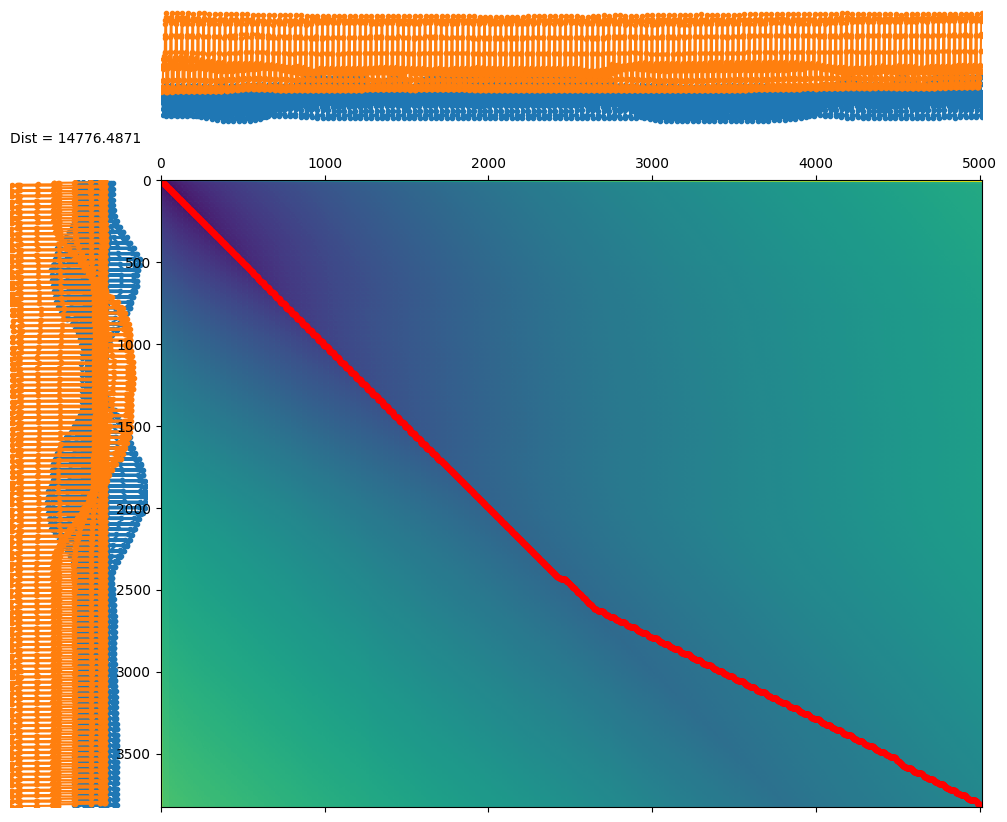

In [14]:
best_path = dtw.best_path(paths)  #take the path with the minimum distance
dtwvis.plot_warpingpaths(dtwKp1, dtwKp2, paths, best_path)

### Show all keypoints in both videos at the same time

In [64]:
width = 600
height = 600
threshold = 0.5

cap1=cv2.VideoCapture(v1)
cap2=cv2.VideoCapture(v2)

cpt = 0

size = (400, 500)
out1 = cv2.VideoWriter('allKp1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video
out2 = cv2.VideoWriter('allKp2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video

while True:
    success, img1 = cap1.read()
    success1, img2 = cap2.read() 

    if success is False or img1 is None:
        break

    if success1 is False or img2 is None:
        break

    for i in range(0, Kp1.shape[0], 3):
        if len(kp1_list[cpt]) != 0:
            x, y = kp1_list[cpt][i+1], kp1_list[cpt][i+2]
            cv2.circle(img1, (x, y), 4, (0, 0, 255), thickness=3)
            
    
    for i in range(0, Kp2.shape[0], 3):
        if len(kp2_list[cpt]) != 0:
            x, y = kp2_list[cpt][i+1], kp2_list[cpt][i+2]
            cv2.circle(img2, (x, y), 4, (0, 0, 255), thickness=3)
            

    img1 = cv2.resize(img1, size) 
    img2 = cv2.resize(img2, size) 

    out1.write(img1)
    out2.write(img2)

    cpt = cpt+1

    cv2.imshow("Video 1", img1)
    cv2.imshow("Video 2", img2)

    key = cv2.waitKey(50)
    if key == ord('q'):
        break

cv2.destroyAllWindows()
out1.release()
out2.release()
cap1.release()
cap2.release()


In [16]:
print(len(best_path))
print(best_path[0:100])


5613
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3), (6, 4), (7, 5), (8, 6), (9, 7), (10, 8), (11, 9), (12, 10), (13, 11), (14, 12), (14, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 36), (38, 36), (39, 37), (40, 38), (41, 39), (42, 40), (43, 41), (44, 42), (45, 43), (46, 44), (47, 45), (47, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 69), (71, 69), (72, 70), (73, 71), (74, 72), (75, 73), (76, 74), (77, 75), (78, 76), (79, 77), (80, 78), (80, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (88, 88), (89, 89), (90, 90), (91, 91), (92, 92), (93, 93)]


### Show Similar keypoints in both videos at the same time

In [17]:
print(dtwKp1.shape)
print(dtwKp2.shape)
print(dtwKp1[0:10])

(3828, 2)
(5016, 2)
[[329 255]
 [342 234]
 [352 234]
 [361 233]
 [317 235]
 [308 235]
 [298 236]
 [377 247]
 [289 249]
 [349 279]]


In [18]:
kp1_list[0]

array([   0,  329,  255,    1,  342,  234,    2,  352,  234,    3,  361,
        233,    4,  317,  235,    5,  308,  235,    6,  298,  236,    7,
        377,  247,    8,  289,  249,    9,  349,  279,   10,  314,  280,
         11,  450,  375,   12,  231,  378,   13,  498,  526,   14,  201,
        535,   15,  507,  679,   16,  173,  686,   17,  519,  726,   18,
        157,  731,   19,  500,  731,   20,  166,  739,   21,  486,  715,
         22,  187,  726,   23,  399,  679,   24,  281,  680,   25,  399,
        888,   26,  270,  894,   27,  402, 1057,   28,  272, 1067,   29,
        389, 1078,   30,  287, 1090,   31,  432, 1138,   32,  224, 1150])

In [19]:
similarKp1 = []
similarKp2 = []

for i in range(0, len(best_path)):
    similarKp1.append(best_path[i][0])
    similarKp1.append(dtwKp1[best_path[i][0]])
    similarKp2.append(best_path[i][1])
    similarKp2.append(dtwKp2[best_path[i][1]])



In [20]:
print(len(similarKp2))
similarKp2[0:10]

11226


[0,
 array([315, 362]),
 1,
 array([298, 341]),
 2,
 array([297, 340]),
 3,
 array([297, 339]),
 3,
 array([297, 339])]

In [21]:
width = 600
height = 600
threshold = 0.5

cap1=cv2.VideoCapture(v1)
cap2=cv2.VideoCapture(v2)

cpt1 = 0


nbrFrames1 = dtwKp1.shape[0] 
nbrFrames2 = dtwKp2.shape[0] 

size = (400, 500)
out1 = cv2.VideoWriter('allSimilar1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video
out2 = cv2.VideoWriter('allSimilar2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video

while True:
    success, img1 = cap1.read()
    success1, img2 = cap2.read() 

    if success is False or img1 is None:
        break

    if success1 is False or img2 is None:
        break

    for i in range(0, len(similarKp1), 2):
            if (similarKp1[i] > cpt1 and similarKp1[i] < cpt1 + 32):
                x, y = similarKp1[i+1][0], similarKp1[i+1][1]
                cv2.circle(img1, (x, y), 4, (0, 0, 255), thickness=3)
        
    for i in range(0, len(similarKp2), 2):
            if (similarKp2[i] > cpt1 and similarKp2[i] < cpt1 + 32):
                x, y = similarKp2[i+1][0], similarKp2[i+1][1]
                cv2.circle(img2, (x, y), 4, (0, 0, 255), thickness=3)

    img1 = cv2.resize(img1, size) 
    img2 = cv2.resize(img2, size) 

    out1.write(img1)
    out2.write(img2)

    cpt1 = cpt1 + 33

    cv2.imshow("Video 1", img1)
    cv2.imshow("Video 2", img2)

    key = cv2.waitKey(20)
    if key == ord('q'):
        break

cv2.destroyAllWindows()
out1.release()
out2.release()
cap1.release()
cap2.release()


In [362]:
allSimilar = []

for i in range(0, len(best_path)):
    allSimilar.append(best_path[i])
    allSimilar.append([dtwKp1[best_path[i][0]], dtwKp2[best_path[i][1]]])
    



In [376]:
32*8

256

In [363]:
allSimilar

[(0, 0),
 [array([329, 255]), array([315, 362])],
 (1, 1),
 [array([342, 234]), array([298, 341])],
 (2, 2),
 [array([352, 234]), array([297, 340])],
 (3, 3),
 [array([361, 233]), array([297, 339])],
 (4, 3),
 [array([317, 235]), array([297, 339])],
 (5, 3),
 [array([308, 235]), array([297, 339])],
 (6, 4),
 [array([298, 236]), array([294, 343])],
 (7, 5),
 [array([377, 247]), array([288, 343])],
 (8, 6),
 [array([289, 249]), array([282, 343])],
 (9, 7),
 [array([349, 279]), array([266, 343])],
 (10, 8),
 [array([314, 280]), array([246, 350])],
 (11, 9),
 [array([450, 375]), array([302, 380])],
 (12, 10),
 [array([231, 378]), array([293, 382])],
 (13, 11),
 [array([498, 526]), array([273, 449])],
 (14, 12),
 [array([201, 535]), array([168, 459])],
 (14, 13),
 [array([201, 535]), array([266, 561])],
 (14, 14),
 [array([201, 535]), array([104, 599])],
 (15, 15),
 [array([507, 679]), array([328, 600])],
 (16, 16),
 [array([173, 686]), array([227, 661])],
 (17, 17),
 [array([519, 726]), ar

In [379]:
width = 600
height = 600
threshold = 0.5

cap1=cv2.VideoCapture(v1)
cap2=cv2.VideoCapture(v2)

cpt1 = 0


nbrFrames1 = 1
nbrFrames2 = 0

size = (400, 500)
out1 = cv2.VideoWriter('allSimilar1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video
out2 = cv2.VideoWriter('allSimilar2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, size) # Output video
cond = True
while True:
    success, img1 = cap1.read()
    success1, img2 = cap2.read() 

    if success is False or img1 is None:
        break

    if success1 is False or img2 is None:
        break

    for i in range(0, len(allSimilar), 2):
        if (allSimilar[i][0] > cpt1 and allSimilar[i][0] < cpt1 + 32):
            x1, y1 = allSimilar[i+1][0]
                
            cv2.circle(img1, (x1, y1), 4, (0, 0, 255), thickness=3)
            

    for i in range(0, len(allSimilar), 2):
        if (allSimilar[i][1] > cpt1 and allSimilar[i][1] < cpt1 + 32 and allSimilar[i][0] >= 224 and allSimilar[i][0] <= 1000):
           
            x2, y2 = allSimilar[i+1][1]    
            
            cv2.circle(img2, (x2, y2), 4, (0, 0, 255), thickness=3)     

    img1 = cv2.resize(img1, size) 
    img2 = cv2.resize(img2, size) 

    out1.write(img1)
    out2.write(img2)

    cpt1 = cpt1 + 33
    
   
    cv2.imshow("Video 2", img2)
    if cond:
        cv2.imshow("Video 1", img1)
    cond = True
    key = cv2.waitKey(20)
    if key == ord('q'):
        break

cv2.destroyAllWindows()
out1.release()
out2.release()
cap1.release()
cap2.release()


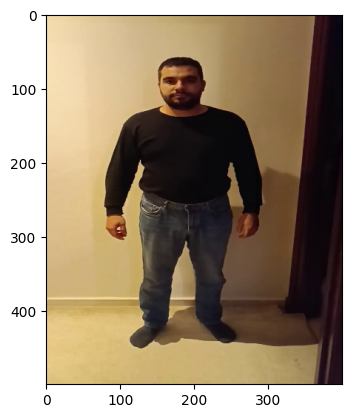

In [329]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("first_frame1.png")
plt.imshow(img, cmap='gray')
plt.show()

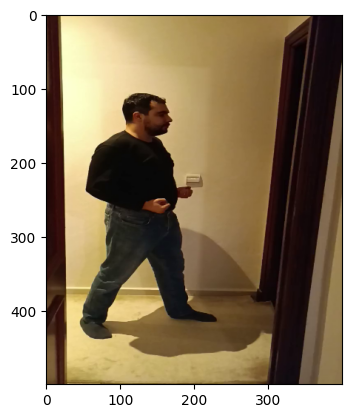

In [330]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("first_frame2.png")
plt.imshow(img, cmap='gray')
plt.show()